This notebook showcases how our best model works. First, we import all necessary libraries.

In [1]:
import sys
sys.path.append('./../')
!{sys.executable} -m pip install gdown h5py

from utils import load_it_data, visualize_img
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path as op
import pandas as pd
import gdown
url = "https://drive.google.com/file/d/1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS/view?usp=share_link"
output = "IT_data.h5"
gdown.download(url, output, quiet=False, fuzzy=True)

try:
    %pip install torchinfo
except:
    print("Couldn't install torchinfo")

# Extra imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchinfo import summary
from torchvision.models import densenet169, DenseNet169_Weights
from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import RidgeCV, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import r2_score
from scipy.stats import pearsonr
import seaborn as sns
import pickle as pk
import joblib
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
seed = 42
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Downloading...
From (original): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS
From (redirected): https://drive.google.com/uc?id=1s6caFNRpyR9m7ZM6XEv_e8mcXT3_PnHS&confirm=t&uuid=76f3d130-21cc-4c3d-8627-b2d4590052d6
To: /home/jupyter/Week6Pt2/IT_data.h5
100%|██████████| 384M/384M [00:02<00:00, 134MB/s]  


Note: you may need to restart the kernel to use updated packages.


Then, we load the data and prepare it.

In [2]:
# Load the data
path_to_data = "" ## Insert the folder where the data is, if you download in the same folder as this notebook then leave it blank
stimulus_train, stimulus_val, stimulus_test, objects_train, objects_val, objects_test, spikes_train, spikes_val = load_it_data(path_to_data)

# Prepare data
stimulus_train = torch.from_numpy(stimulus_train).to(device)
stimulus_train.require_grad = False
stimulus_val = torch.from_numpy(stimulus_val).to(device)
stimulus_val.require_grad = False

Next, we define all helper functions.

In [7]:
# Function to extract and return the activations of some layer of interest
# This function is actually somewhat of a modified forward function that just gets what we need.
def layerActivationExtractor(model, input, layer_name):
    """
    Arguments :
    - model : the densenet-169 model
    - input : the images, of size N_images x H x W
    - layer_name : the name of the layer of interest
    
    Output : activations, ndarray of size N_images x (shape_activations)
    
    Description :
    This function gets the activations for all images for one layer of interest.
    It sequentially passes the input through the layers manually, stopping after the layer of interest to return the activations.
    In order, and thanks to the summary in the previous cell, we know that the input passes through the layers... 
    - conv0
    - norm0
    - relu0
    - pool0
    - denseblock1
    - transition1
    - denseblock2
    - transition2
    - denseblock3
    - transition3
    - denseblock4
    - norm5
    - classifier
    """
    if layer_name not in ["conv0", "transition1", "transition2", "transition3", "norm5"]:
        raise ValueError("Non-compatible layer name.")
    
    all_activations = np.repeat(None, input.shape[0])
    for i in range(input.shape[0]):
        # Resize each to the appropriate size of 1 x 3 x 224 x 224
        model_input = input[i].unsqueeze(0)
        # Pass through conv1
        activation = model.features.conv0(model_input)
        # This is a layer of interest, let's grab the activations
        if layer_name == "conv0":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()
            continue

        # Pass through norm0
        activation = model.features.norm0(activation)
        # Pass through relu0
        activation = model.features.relu0(activation)
        # Pass through pool0
        activation = model.features.pool0(activation)

        # Pass through denseblock1
        activation = model.features.denseblock1(activation)
        # Pass through transition1
        activation = model.features.transition1(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "transition1":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through denseblock2
        activation = model.features.denseblock2(activation)
        # Pass through transition2
        activation = model.features.transition2(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "transition2":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through denseblock3
        activation = model.features.denseblock3(activation)
        # Pass through transition3
        activation = model.features.transition3(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "transition3":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()

        # Pass through denseblock4
        activation = model.features.denseblock4(activation)
        # Pass through norm5
        activation = model.features.norm5(activation)
        # This is a layer of interest, let's grab the activations
        if layer_name == "norm5":
            activation.require_grad = False
            all_activations[i] = activation.flatten().cpu().detach().numpy()
    
    # We don't care about the model's actual output, so we don't pass through the final layer.

    return np.stack(all_activations)

# Define the two evaluation metrics
## Pearson correlation
def pearson_correlation(y_true, y_pred):
      n_neurons = y_true.shape[1]
      corrs = np.zeros(n_neurons)
      for i in range(n_neurons):
            corrs[i] = pearsonr(y_true[:, i], y_pred[:, i])[0]
      return corrs

## Explained variance
def R_squared(y_true, y_pred):
      n_neurons = y_true.shape[1]
      Rs_squared = np.zeros(n_neurons)
      for i in range(n_neurons):
            Rs_squared[i] = r2_score(y_true[:, i], y_pred[:, i])
      return Rs_squared

Now, we load all prequired models.

In [5]:
# Loading the pretrained ResNet50 model
weights = DenseNet169_Weights.DEFAULT
model = densenet169(weights = weights, progress = True).to(device)
# As we won't be training the model (it's already pretrained, we just want the activations in the intermediate layers) we can set require_grad to False for all params.
for param in model.parameters():
    param.require_grad = False

# Load fitted PCA model
pca = joblib.load("pca.joblib")

# Load fitted ridge model
ridge = joblib.load("ridge.joblib")

Now, we make predictions on the validation set.

In [8]:
# First extract activations
activations = layerActivationExtractor(model, stimulus_val, "norm5")
# Then extract PCs
pcs = pca.transform(activations)
# Finally, predict the spikes
y_pred = ridge.predict(pcs)

Finally, we plot the results.

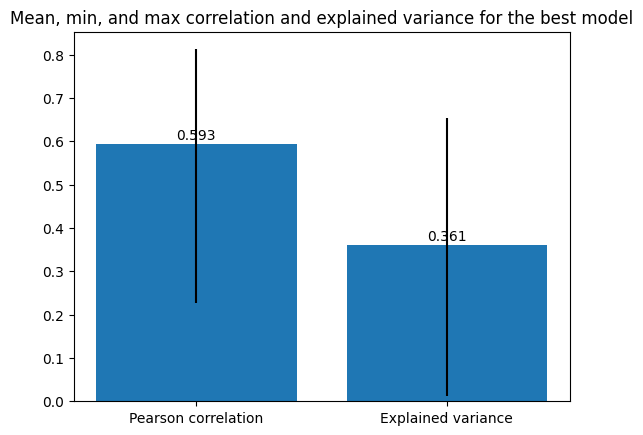

In [15]:
metric_names = ["Pearson correlation", "Explained variance"]

# Compute correlation and explained variance
corr = pearson_correlation(spikes_val, y_pred)
explVar = R_squared(spikes_val, y_pred)

# Plot correlation and explained variance in a barplot
plt.bar(range(2), [np.mean(corr), np.mean(explVar)], yerr = [[np.mean(corr)-np.min(corr), np.mean(explVar)-np.min(explVar)], [np.max(corr)-np.mean(corr), np.max(explVar)-np.mean(explVar)]])

# Polish graph
plt.text(0, np.mean(corr) + 0.01, s = np.round(np.mean(corr),3),ha='center')
plt.text(1, np.mean(explVar) + 0.01, s = np.round(np.mean(explVar),3),ha='center')
plt.xticks(range(2), metric_names)

plt.title('Mean, min, and max correlation and explained variance for the best model')
plt.show()

And we find the exact same results as in the report.

N.B. to create the pca.joblib and ridge.joblib files, run the next file.

In [ ]:
layer_name = "norm5"
# Get activations
activations_train = layerActivationExtractor(model, stimulus_train, layer_name) 
activations_val = layerActivationExtractor(model, stimulus_val, layer_name)

# Run a PCA and get the PCs
n_PCs = 1000
pca = PCA(n_components = n_PCs)
pca = pca.fit(np.concatenate((activations_train, activations_val), axis = 0))
pcs_train = pca.transform(activations_train)
pcs_val = pca.transform(activations_val)

# Save the trained PCA in a pickle file
joblib.dump(pca, "pca.joblib") 

# Run ridge regression
ridge = Ridge(alpha=109000, solver='svd')
ridge.fit(pcs_train,spikes_train)

joblib.dump(ridge, "ridge.joblib")